# Ultimate Technologies Inc. Take-Home Challenge

created on Google Colab.

## Importing Libraries & Load Data

In [1]:
# Import Standard Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [19]:
# Import Modeling Libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from scipy.stats import ttest_ind

In [20]:
# Import Additional Libraries
from copy import deepcopy
from matplotlib.dates import HourLocator

In [32]:
# Changing default plot sizes 
plt.rcParams['figure.figsize'] = [8, 8]

## Loading Dataset

In [3]:
# Accessing Google Drive by mounting it locally
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Location on Google Drive
repo = 'challenge_ultimate'
%cd /content/drive/MyDrive/colab_notebooks/GitHub/{repo}/

# Load data files into pandas
logins = pd.read_json('logins.json',convert_dates=True)
ultimate = pd.read_json('ultimate_data_challenge.json')

/content/drive/MyDrive/colab_notebooks/GitHub/challenge_ultimate


In [5]:
# Unmount Google Drive.
drive.flush_and_unmount()

## Data Wrangling

### Logins Dataset

In [39]:
logins.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [40]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


### Ulitamate Dataset

In [41]:
ultimate.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

In [43]:
ultimate.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [44]:
ultimate.describe()

trips_in_first_30_days  avg_rating_of_driver     avg_surge  \
count            50000.000000          41878.000000  50000.000000   
mean                 2.278200              4.601559      1.074764   
std                  3.792684              0.617338      0.222336   
min                  0.000000              1.000000      1.000000   
25%                  0.000000              4.300000      1.000000   
50%                  1.000000              4.900000      1.000000   
75%                  3.000000              5.000000      1.050000   
max                125.000000              5.000000      8.000000   

          surge_pct   weekday_pct      avg_dist  avg_rating_by_driver  
count  50000.000000  50000.000000  50000.000000          49799.000000  
mean       8.849536     60.926084      5.796827              4.778158  
std       19.958811     37.081503      5.707357              0.446652  
min        0.000000      0.000000      0.000000              1.000000  
25%        0.000000     33.300000      2.420000              4.700000  
50%        0.000000     66.700000      3.880000              5.000000  
75%        8.600000    100.000000      6.940000              5.000000  
max      100.000000    100.000000    160.960000              5.000000

In [46]:
# Characterizing the NaN within the data.
ultimate.isna().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64

## Exploratory Data Analysis

In [10]:
# Creating a Counter for logins by 15-minute intervals.
logins_count = deepcopy(logins)
logins_count["count"] = 1
logins_count = logins_count.set_index("login_time")
logins_count_15min = logins_count.groupby(pd.Grouper(freq="15Min")).sum()
logins_count_15min.index.name = "DateTime"

In [13]:
# Creating a Counter for logins by day intervals.
logins_count_day = logins_count_15min.groupby(logins_count_15min.index.date).mean()
logins_count_day = logins_count_day[1 : -1]
logins_count_day.index.name = "Date"

Text(0.5, 1.0, 'Login Count by day')

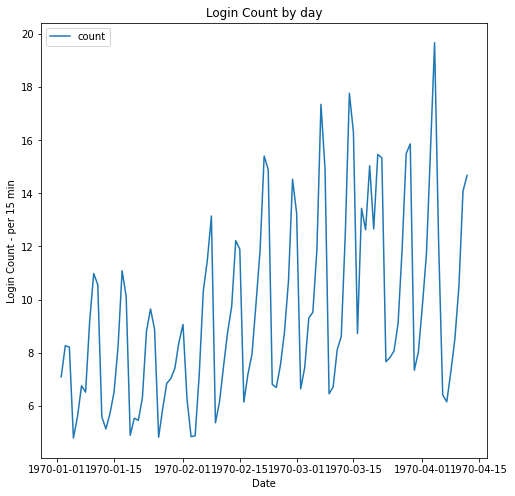

In [35]:
# Creating plot of login count by day.
logins_count_day.plot(y="count")
plt.ylabel("Login Count - per 15 min")
plt.title("Login Count by day")

Text(0.5, 1.0, 'Login Count - Day of Week')

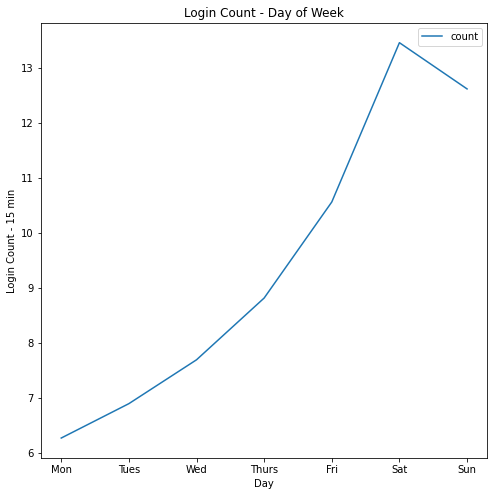

In [36]:
# Plot Mean Count by Day of the Week
logins_count_week = logins_count_15min["1970-01-02" : "1970-04-12"].groupby(logins_count_15min["1970-01-02" : "1970-04-12"].index.weekday).mean()
logins_count_week.index.name = "Day"

logins_count_week.plot(y="count")
plt.xticks(ticks=range(7), labels=["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"])
plt.ylabel("Login Count - 15 min")
plt.title("Login Count - Day of Week")

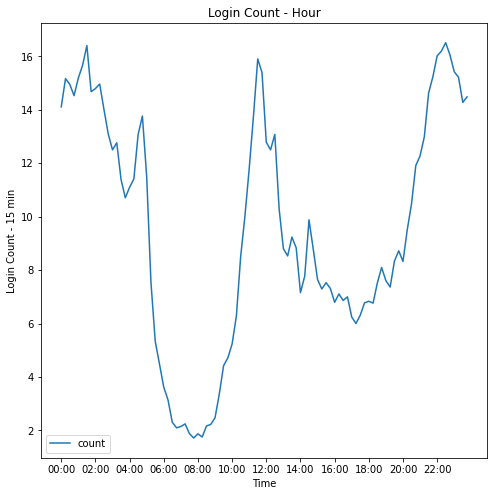

In [37]:
# Plot Mean Login Count by Hour
logins_count_ave_day = logins_count_15min.groupby(logins_count_15min.index.time).mean()
logins_count_ave_day.index.name = "Time"

logins_count_ave_day.plot(y="count")
plt.xticks([7200 * h for h in range(12)])
plt.ylabel("Login Count - 15 min")
plt.title("Login Count - Hour")
plt.show()

Text(0.5, 1.0, 'Login Rate by Time with Days of the Week')

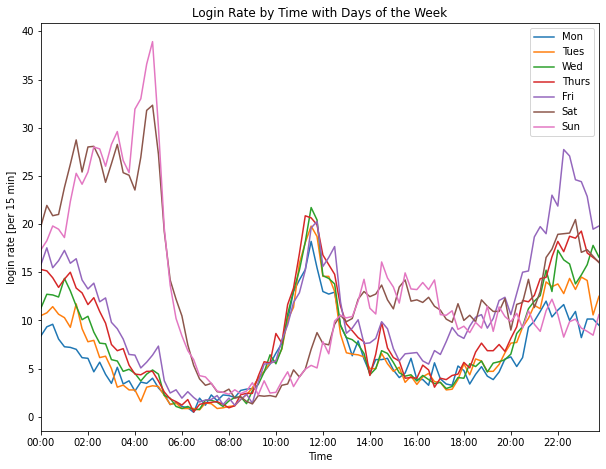

In [38]:
# Plot Mean Time for Each Day of the Week

pd.plotting.register_matplotlib_converters()

logins_count_ave_dayofweek_time = logins_count_15min.groupby([logins_count_15min.index.weekday, logins_count_15min.index.time]).mean()

day_of_week = ["Mon", "Tues", "Wed", "Thurs", "Fri", "Sat", "Sun"]
plt.figure(figsize=(10, 7.5))
for i in range(7):
    plt.plot(logins_count_ave_dayofweek_time.loc[i], label=day_of_week[i])
plt.ylabel("login rate [per 15 min]")
plt.xticks([7200 * h for h in range(12)])
plt.xlabel("Time")
plt.legend(loc="upper right")
plt.xlim([0, 3600 * 23.75])
plt.title("Login Rate by Time with Days of the Week")